# XGBoost trainer

This notebook function handles training and logging of xgboost models **only**, exposing both the sklearn and low level api"s.  Much of the internal workings of this function have been borrowed from `sklearn_classifier`, please see that function for more details.

## steps
1. **generate an xgboost model configuration** by selecting one of 5 available types
   * [x] classifier
   * [ ] regressor
   * [ ] ranker
   * [ ] rf_classifier (rf: random forest)
   * [ ] rf_regressor
2. **get a sample of data** from a data source
   * select all rows using -1
   * select a random sample of rows using a negative integer
   * select consecutive rows using a positive integer
3. **split the data** into train, validation, and test sets 
   * the test set is saved as an artifact and never seen again until testing
   * WIP: this will be parametrized to produce cross-validator splits (one way of performing CV)
4. **train the model** using xgboost in one of its flavours (dask, gpu, mpi...)
5. **pickle / serialize the model**
   * models can be pickled or saved as json (a newer xgboost format)
6. **evaluate the model**
   * a custom evaluator can be provided, see function doc for details

In [1]:
# nuclio: ignore
import nuclio

In [2]:
### mlrun 0.4.7:

# %nuclio config kind = "job"
# %nuclio config spec.build.baseImage = "mlrun/ml-models"
# %nuclio cmd -c pip install git+https://github.com/mlrun/mlutils.git@development scikit-plot

In [3]:
### mlrun 0.4.8
%nuclio config kind = "job"
%nuclio config spec.image = "yjbds/ml-models:0.4.8"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'yjbds/ml-models:0.4.8'


In [4]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
from mlutils import (get_sample,
                     get_splits,
                     gen_sklearn_model,
                     create_class, 
                     eval_class_model,
                     log_model)

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact, TableArtifact

from cloudpickle import dumps
import pandas as pd
import os
from typing import List

## generate an xgb model

generate a model config using the xgboost's sklearn api

In [6]:
def _gen_xgb_model(model_type: str, xgb_params: dict):
    """generate an xgboost model
    
    Multiple model types that can be estimated using
    the XGBoost Scikit-Learn API.
    
    Input can either be a predefined json model configuration or one
    of the five xgboost model types: "classifier", "regressor", "ranker",
    "rf_classifier", or "rf_regressor".
    
    In either case one can pass in a params dict to modify defaults values.
    
    Based on `mlutils.models.gen_sklearn_model`, see the function
    `sklearn_classifier` in this repository.
    
    :param model_type: one of "classifier", "regressor",
                       "ranker", "rf_classifier", or
                      "rf_regressor"
    :param xgb_params: class init parameters
    """
    # generate model and fit function
    mtypes = {
        "classifier"   : "xgboost.XGBClassifier",
        "regressor"    : "xgboost.XGBRegressor",
        "ranker"       : "xgboost.XGBRanker",
        "rf_classifier": "xgboost.XGBRFClassifier",
        "rf_regressor" : "xgboost.XGBRFRegressor"
    }
    if model_type.endswith("json"):
        model_config = model_type
    elif model_type in mtypes.keys():
        model_config = mtypes[model_type]
    else:
        raise Exception("unrecognized model type, see help documentation")

    return gen_sklearn_model(model_config, xgb_params)

## train

In [7]:
def train_model(
    context: MLClientCtx,
    model_type: str,
    dataset: DataItem,
    label_column: str = "labels",
    encode_cols: dict = {},
    sample: int = -1,
    imbal_vec = [],
    test_size: float = 0.25,
    valid_size: float = 0.75,
    model_evaluator = None,
    random_state: int = 1,
    models_dest: str = "models",
    plots_dest: str = "plots",
    eval_metrics = "error",
    file_ext: str = "parquet",
    model_pkg_file: str = "",    
) -> None:
    """train an xgboost model.
    
    :param context:           the function context
    :param model_type:        the model type to train, "classifier", "regressor"...
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded.
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param imbal_vec:         ([]) vector of class weights seen in sample
    :param test_size:         (0.05) test set size
    :param valid_size:        (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param model_evaluator:   (None) a custom model evaluator can be specified
    :param random_state:      (1) sklearn rng seed
    :param models_dest:       destination subfolder for model artifacts
    :param plots_dest:        destination subfolder for plot artifacts
    :param eval_metrics:      (["error", "auc"]) learning curve metrics
    :param file_ext:          format for test_set_key hold out data
    """
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # hot-encode
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=True)
    
    # split the sample into train validate, test and calibration sets:
    (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = \
        get_splits(raw, labels, 3, test_size, 1-valid_size, random_state)
    
    # set aside some test data
    context.log_dataset("test-set",
                        df=pd.concat([xtest, ytest], axis=1),
                        format=file_ext, index=False)

    # get model config
    model_config = _gen_xgb_model(model_type, 
                                  context.parameters.items())

    # imbalance param, binary, this needs to be checked:
    if len(imbal_vec) == 2:
        scale_pos_weight = imbal_vec[0]/imbal_vec[1]
        model_config["CLASS"].update({"scale_pos_weight": scale_pos_weight})

    # create model instance
    XGBBoostClass = create_class(model_config["META"]["class"])

    # instantiate the class with our updated CLASS params:    
    model = XGBBoostClass(**model_config["CLASS"])

    # update the model config with training data and callbacks:
    model_config["FIT"].update({"X": xtrain, 
                                "y": ytrain.values,
                                "eval_set":[(xtrain, ytrain), (xvalid, yvalid)],
                                "eval_metric": eval_metrics})

    # run the fit with our updated FIT params:
    model.fit(**model_config["FIT"])

    # evaluate model:
    if model_evaluator:
        eval_metrics = model_evaluator(context, xvalid, yvalid, model)
    else:
        eval_metrics = eval_class_model(context, xvalid, yvalid, model)

    # log it all:
    log_model(context, dumps(model), eval_metrics)


In [8]:
# nuclio: end-code

### xgboost trainer setup

the following task parameters might be common to several runs:

In [9]:
task_params = {
    "name" : "tasks xgb cpu trainer",
    "params" : {
        "sample"             : -1,
        "label_column"       : "labels",
        "test_size"          : 0.30,
        "train_val_split"    : 0.75,
        "random_state"       : 1,
        "n_jobs"             : -1,
        "models_dest"        : 'xgboost_models'}}

### set model parameters and run locally

* update the task and run a local trainer
* optionally customize parameters

please note that the following parameters have been chosen without regard to optimization and model tuning

**notes**
* if running a __binary classification__ set `CLASS_objective` to `binary:logistic`, and DO NOT set `CLASS_num_class` to 2
* if running a __mulitclass estimation__ set `CLASS_objective` to `multi:softmax` and `CLASS_num_class` equal to the number of classes

In [17]:
gpus = False

task_params["params"].update({
        "model_type"              : "classifier",
        "CLASS_tree_method"       : "gpu_hist" if gpus else "hist",
        "CLASS_objective"         : "multi:softmax",
        #"CLASS_objective"         : "binary:logistic",
        "CLASS_num_class"         : 4,
        "CLASS_booster"           : "gbtree",
        "FIT_verbose"             : 0,
        "eval_metrics"            : ["merror"],
        #"eval_metrics"            : ["error"],
        "imbal_vec"               : [],
        "label_column"            : "labels"})

In [19]:
DATA_REPO = "https://raw.githubusercontent.com/yjb-ds/testdata/master/" 

# choose a binary or multiclass dataset
#DATA_PATH = "data/clf-k2-m24-n10k-bal.csv" # BINARY
DATA_PATH = "data/clf-k4-m24-n10k-imb.csv" # MULTICLASS

DATA_URL = f"{DATA_REPO}/{DATA_PATH}"

[mlrun] 2020-05-26 02:47:01,028 starting run tasks xgb cpu trainer uid=996ce0a8411140539c17ab4e0e01280d  -> http://mlrun-api:8080
[mlrun] 2020-05-26 02:47:01,563 log artifact test-set at /User/artifacts/test-set.parquet, size: 701200, db: Y
[mlrun] 2020-05-26 02:47:02,554 log artifact confusion-matrix-normalized at /User/artifacts/plots/confusion-matrix-normalized.html, size: 21286, db: Y
[mlrun] 2020-05-26 02:47:02,614 log artifact learning curve - erreur at /User/artifacts/plots/learning curve - erreur.html, size: 15686, db: Y
[mlrun] 2020-05-26 02:47:02,643 log artifact precision-recall-multiclass at /User/artifacts/plots/precision-recall-multiclass.html, size: 1766, db: Y
[mlrun] 2020-05-26 02:47:02,721 log artifact roc-multiclass at /User/artifacts/plots/roc-multiclass.html, size: 28685, db: Y
[mlrun] 2020-05-26 02:47:02,743 log artifact model at /User/artifacts/models/, size: 5004, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...0e01280d,0,May 26 02:47:01,completed,tasks xgb cpu trainer,v3io_user=adminkind=handlerowner=adminhost=jupyter-f9d6597fd-ns9cj,dataset,sample=-1label_column=labelstest_size=0.3train_val_split=0.75random_state=1n_jobs=-1models_dest=xgboost_modelsmodel_type=classifierCLASS_tree_method=histCLASS_objective=multi:softmaxCLASS_booster=gblinearFIT_verbose=0eval_metrics=['merror']imbal_vec=[]CLASS_num_class=4,test-accuracy=0.7022857142857143test-error=0.2977142857142857auc-micro=0.8952766258503401auc-weighted=0.8689454000278214f1-score=0.7022857142857143precision_score=0.7022857142857143recall_score=0.7022857142857143,test-setconfusion-matrix-normalizedlearning curve - erreurprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 996ce0a8411140539c17ab4e0e01280d --project default , !mlrun logs 996ce0a8411140539c17ab4e0e01280d --project default
[mlrun] 2020-05-26 02:47:02,823 run executed, status=completed


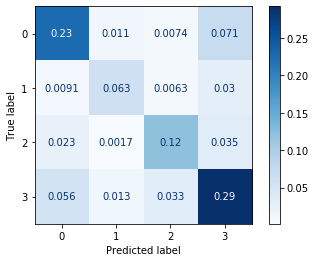

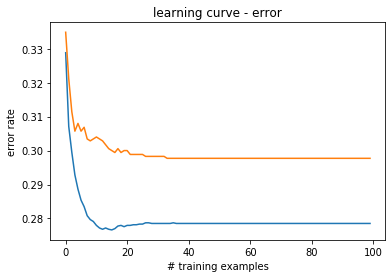

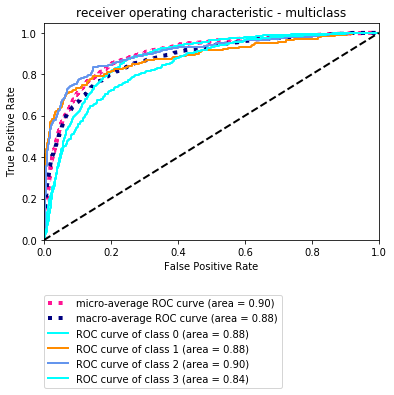

In [26]:
from mlrun import run_local, NewTask, mlconf

run = run_local(
    NewTask(**task_params),
    handler=train_model,
    inputs={"dataset"  : DATA_URL},
    artifact_path=mlconf.artifact_path)

### run remotely

* to run remotely an mlrun function is created from the annotated notebook code above
* it is then run in a pod using the chosen image
* if the `commands` parameter is not `None`, then the image will serve as a base image, and those packages listed in `commands` will be installed

In [27]:
from mlutils import create_function

fn_params = {
    "name"            : "xgb_trainer",
    "project"         : "functions",
    "default_handler" : "train_model",
    "desc"            : "train multiple model types using xgboost",
    "categories"      : ["training", "ml", "experimental"],
    "labels"          : {"author": "yjb", "framework": "xgboost"},
    "kind"            : "job",
    "image"           : "yjbds/ml-models",
    "commands"        : None,
    "tag"             : mlconf.images_tag}

### running a loop
first create the function, then feed it one or more tasks

In [28]:
fn = create_function(fn_params, path='.')

[mlrun] 2020-05-26 02:47:38,701 function spec saved to path: ./function.yaml


In [29]:
# only for v0.4.7:
#  fn.deploy(skip_deployed=True, with_mlrun=False)

outputs = []
for booster in ["gbtree", "gblinear"]:
    task_copy = task_params.copy()
    
    task_copy["params"].update({"CLASS_booster" : booster})
    
    # adjust paramters for the specifi booster:
    if booster is "gblinear":
        # add you super duper parameter value here to fix the linear estimator!
        # task_copy["params"].update({"CLASS_booster" : booster})
        # or add feature transforms (todo)
        pass

    output = fn.run(
        NewTask(**task_copy),
        inputs={"dataset"  : DATA_URL},
        artifact_path=mlconf.artifact_path)
    
    # for local debugging:
    outputs.append(output.outputs)

[mlrun] 2020-05-26 02:47:38,741 starting run tasks xgb cpu trainer uid=59759aef548c4800853c94d467f5579c  -> http://mlrun-api:8080
[mlrun] 2020-05-26 02:47:38,887 Job is running in the background, pod: tasks-xgb-cpu-trainer-tb6p2
[mlrun] 2020-05-26 02:47:44,502 starting local run: main.py # train_model
[mlrun] 2020-05-26 02:47:45,813 log artifact test-set at /User/artifacts/test-set.parquet, size: 702000, db: Y
[mlrun] 2020-05-26 02:47:50,052 log artifact confusion-matrix-normalized at /User/artifacts/plots/confusion-matrix-normalized.html, size: 3286, db: Y
[mlrun] 2020-05-26 02:47:50,088 log artifact learning curve - erreur at /User/artifacts/plots/learning curve - erreur.html, size: 3282, db: Y
[mlrun] 2020-05-26 02:47:50,209 log artifact feature-importances at /User/artifacts/plots/feature-importances.html, size: 13618, db: Y
[mlrun] 2020-05-26 02:47:50,251 log artifact precision-recall-multiclass at /User/artifacts/plots/precision-recall-multiclass.html, size: 5526, db: Y
[mlrun] 2

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...67f5579c,0,May 26 02:47:45,completed,tasks xgb cpu trainer,v3io_user=adminkind=jobowner=adminhost=tasks-xgb-cpu-trainer-tb6p2,dataset,sample=-1label_column=labelstest_size=0.3train_val_split=0.75random_state=1n_jobs=-1models_dest=xgboost_modelsmodel_type=classifierCLASS_tree_method=histCLASS_objective=multi:softmaxCLASS_booster=gbtreeFIT_verbose=0eval_metrics=['merror']imbal_vec=[]CLASS_num_class=4,test-accuracy=0.8765714285714286test-error=0.12342857142857143auc-micro=0.9745213605442177auc-weighted=0.9697348144249626f1-score=0.8765714285714286precision_score=0.8765714285714286recall_score=0.8765714285714286,test-setconfusion-matrix-normalizedlearning curve - erreurfeature-importancesprecision-recall-multiclassroc-multiclassfeature-importances-tblmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 59759aef548c4800853c94d467f5579c  , !mlrun logs 59759aef548c4800853c94d467f5579c 
[mlrun] 2020-05-26 02:47:54,408 run executed, status=completed
[mlrun] 2020-05-26 02:47:54,409 starting run tasks xgb cpu trainer uid=a7c833fff1ac497caed79cf5f175116e  -> http://mlrun-api:8080
[mlrun] 2020-05-26 02:47:54,571 Job is running in the background, pod: tasks-xgb-cpu-trainer-jx7lt
[mlrun] 2020-05-26 02:47:58,370 starting local run: main.py # train_model
[mlrun] 2020-05-26 02:48:00,271 log artifact test-set at /User/artifacts/test-set.parquet, size: 702000, db: Y
[02:48:00] WARNING: /workspace/src/learner.cc:480: 
Parameters: { tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[mlrun] 2020-05-26 02:48:01,506 log

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...f175116e,0,May 26 02:47:59,completed,tasks xgb cpu trainer,v3io_user=adminkind=jobowner=adminhost=tasks-xgb-cpu-trainer-jx7lt,dataset,sample=-1label_column=labelstest_size=0.3train_val_split=0.75random_state=1n_jobs=-1models_dest=xgboost_modelsmodel_type=classifierCLASS_tree_method=histCLASS_objective=multi:softmaxCLASS_booster=gblinearFIT_verbose=0eval_metrics=['merror']imbal_vec=[]CLASS_num_class=4,test-accuracy=0.7022857142857143test-error=0.2977142857142857auc-micro=0.8952766258503401auc-weighted=0.8689454000278214f1-score=0.7022857142857143precision_score=0.7022857142857143recall_score=0.7022857142857143,test-setconfusion-matrix-normalizedlearning curve - erreurprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run a7c833fff1ac497caed79cf5f175116e  , !mlrun logs a7c833fff1ac497caed79cf5f175116e 
[mlrun] 2020-05-26 02:48:03,892 run executed, status=completed



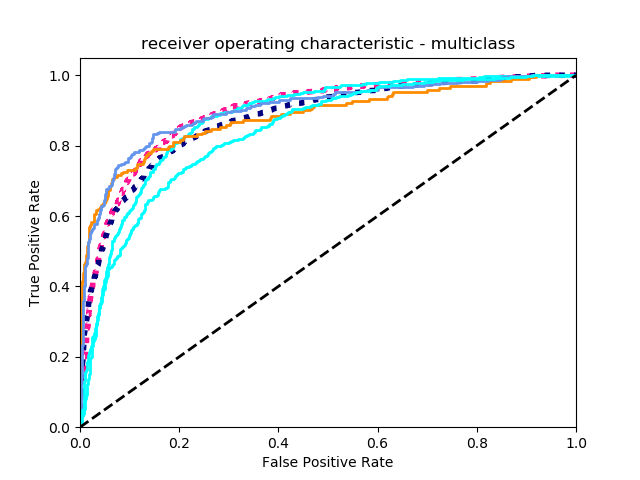

In [30]:
from IPython.display import HTML
HTML(filename=outputs[0]["roc-multiclass"])


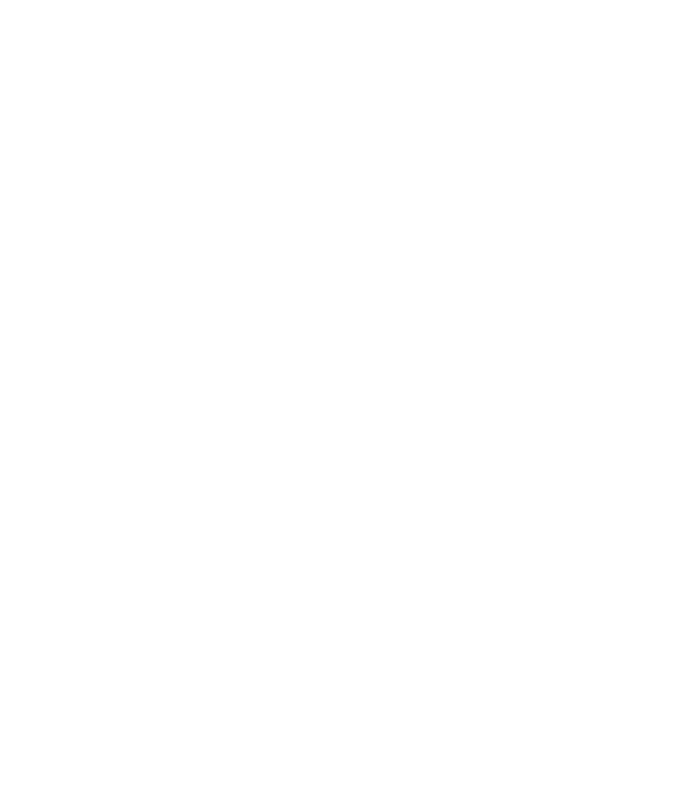

In [31]:
HTML(filename=outputs[1]["precision-recall-multiclass"])